In [1]:
import matplotlib.pyplot as plt
import numpy as np
import bemcs
import warnings
import gmsh

warnings.filterwarnings("ignore")


# function to create mesh
def create_mesh(Lscale, bimaterial_depth, meshsize=0.4):
    # construct a triangle mesh (with thickness = 0.2 units)
    box = np.array(
        [
            [-Lscale, bimaterial_depth * 1.2],
            [-Lscale, bimaterial_depth * 0.8],
            [Lscale, bimaterial_depth * 0.8],
            [Lscale, bimaterial_depth * 1.2],
        ]
    )

    # Initialize the gmsh API
    gmsh.initialize()

    # Create a new model
    gmsh.model.add("rectangle")

    # Define the rectangle vertices
    p1 = gmsh.model.geo.addPoint(box[0, 0], box[0, 1], 0)
    p2 = gmsh.model.geo.addPoint(box[1, 0], box[1, 1], 0)
    p3 = gmsh.model.geo.addPoint(box[2, 0], box[2, 1], 0)
    p4 = gmsh.model.geo.addPoint(box[3, 0], box[3, 1], 0)

    # Define the lines
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)

    # Define the curve loop and plane surface
    curve_loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
    plane_surface = gmsh.model.geo.addPlaneSurface([curve_loop])

    # Synchronize to create the surface
    gmsh.model.geo.synchronize()

    # Define the mesh generation options
    gmsh.option.setNumber("Mesh.Algorithm", 2)  # Delaunay
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.1)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", meshsize)

    # Generate the 2D mesh
    gmsh.model.mesh.generate(2)

    # Extract the nodes and elements
    node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
    node_coords = node_coords.reshape(-1, 3)[:, :2]  # Only take x and y coordinates

    element_types, element_tags, element_node_tags = gmsh.model.mesh.getElements(tag=2)
    triangles = (
        element_node_tags[1].reshape(-1, 3) - 1
    )  # Convert to zero-based indexing
    # gmsh.model.mesh
    # Finalize the gmsh API
    gmsh.finalize()

    Ntri = len(triangles[:, 0])

    xm = np.zeros((Ntri, 1))
    ym = np.zeros((Ntri, 1))
    for i in range(0, Ntri):
        xm[i] = np.mean(node_coords[triangles[i, :], 0])
        ym[i] = np.mean(node_coords[triangles[i, :], 1])

    return node_coords, triangles, xm, ym

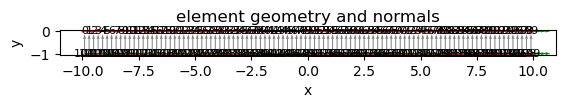

In [2]:
# Elastic parameter (shear modulus)
mu = 1.0
Lscale = 10
npts_layer = 101
bimaterial_depth = -1.0
mu_deep = 5.0
mu_shallow = 1.0
beta = (mu_deep - mu_shallow) / mu_shallow

els_source = bemcs.initialize_els()
els = bemcs.initialize_els()
els_topo = bemcs.initialize_els()

# setup a fault geometry (source) - in this case it is a semi-infinite strike-slip fault
els_source.x1 = np.array([-0.0])
els_source.y1 = np.array([-0.0])
els_source.x2 = np.array([0.0])
els_source.y2 = np.array([-1.5])
bemcs.standardize_els_geometry(els_source, reorder=False)

# horizontal layers (at free surface + bimaterial)
xvals = np.linspace(-Lscale, Lscale, npts_layer)
els.x1 = np.hstack([xvals[0:-1], xvals[0:-1]])
els.x2 = np.hstack([xvals[1:], xvals[1:]])
els.y1 = np.hstack([xvals[0:-1] * 0, xvals[0:-1] * 0 + bimaterial_depth])
els.y2 = np.copy(els.y1)
bemcs.standardize_els_geometry(els, reorder=False)
topoindex = els.y1 == 0
bemcs.plot_els_geometry(els)

# only free surface (topography)
els_topo.x1 = xvals[0:-1]
els_topo.x2 = xvals[1:]
els_topo.y1 = np.zeros_like(els_topo.x1)
els_topo.y2 = np.zeros_like(els_topo.x1)
bemcs.standardize_els_geometry(els_topo, reorder=False)

# Construct triangle mesh of the bimaterial interface

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000190958s, CPU 0.000259s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.00228679s, CPU 0.002276s)
Info    : 244 nodes 490 elements


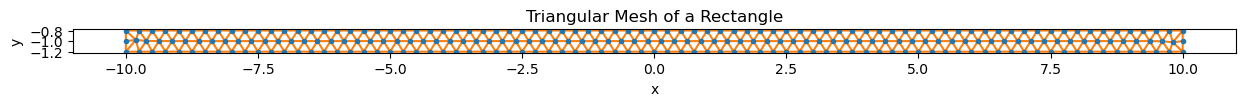

In [3]:
# construct triangle mesh
node_coords, triangles, xm, ym = create_mesh(Lscale, bimaterial_depth, meshsize=0.25)
# scale_factor = 1.0
# node_coords[:, 1] = (
#     node_coords[:, 1] - bimaterial_depth
# ) / scale_factor + bimaterial_depth
# ym = (ym - bimaterial_depth) / scale_factor + bimaterial_depth
# store centroids of each triangle
Ntri = len(triangles[:, 0])


# Plot the mesh
plt.figure(figsize=(15, 5))
plt.plot(node_coords[:, 0], node_coords[:, 1], ".")
plt.triplot(node_coords[:, 0], node_coords[:, 1], triangles)
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
# plt.ylim([-1.2, -0.8])
# plt.xlim([-2.0, 2.0])
plt.title("Triangular Mesh of a Rectangle")
plt.show()

# Construct kernels and solve BEM problem

The general solution to heterogeneous elastic properties can be written in terms of spatially variable body forces of the form,
$$
\nabla^2 u = -\frac{1}{\mu}\left(\mu_{,x}u_{,x} + \mu_{,y}u_{,y} \right) = \alpha u_{,x} + \beta u_{,y}
$$ 
where $\alpha,\beta$ are the spatial logarithmic gradients of $\mu$ i.e., $-\frac{\mu_{,i}}{\mu}$. The right side contains all the terms related to heterogeneity, which turn out to be linear in $u_{,i}$, and so are perfectly suited for Greens Functions calculations.

### Case of purely vertical stratification
In the case of a layered elastic material, $\alpha = 0$ and we can neglect $u_{,x}$ for a flat free surface. This gives us,

$$
\begin{bmatrix} \phi_t \\ \phi_b \end{bmatrix} = 
\begin{bmatrix} 
-\beta\mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_t}) & 
I - \beta\mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_b})
\\
\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_t}) & 
\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_b})
\end{bmatrix}^{-1}
\begin{bmatrix}
\beta u_{,y_0}(\mathbf{x_b}) \\
-u_{,y_0}(\mathbf{x_t})
\end{bmatrix}
$$

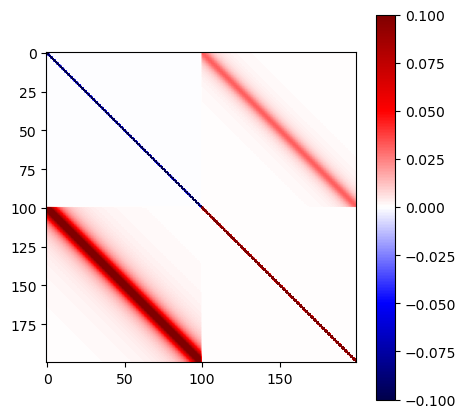

In [4]:
dr = -1e-9
xo = els.x_centers + dr * els.x_normals
yo = els.y_centers + dr * els.y_normals
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_slip_antiplane(
    xo, yo, els_source, mu
)
# quadcoefs = np.array([1, 1, 1])
quadcoefs = bemcs.phicoef(np.array([-1.0, 0, 1.0]), np.array([0.0, 1.0, 0.0]), a=1.0)

# compute grad(u) due to source at els
# (σ = 2με, ε = grad(u)/2 i.e., du/dx = σ/μ)
dudx0 = K_sx @ quadcoefs
dudy0 = K_sy @ quadcoefs

# compute els force kernels [Nobs x 2 x Nsources]
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els, mu)
# construct constant kernels from linear kernels for this simple example
# (σ = 2με, ε = grad(u)/2 i.e., du/dx = σ/μ)
K_x = np.sum(K_sx, axis=1)
K_y = np.sum(K_sy, axis=1)

kernel = np.vstack(
    [
        np.hstack([K_y[topoindex][:, topoindex], K_y[topoindex][:, ~topoindex]]),
        np.hstack(
            [
                -beta * K_y[~topoindex][:, topoindex],
                np.eye(npts_layer - 1) - beta * K_y[~topoindex][:, ~topoindex],
            ]
        ),
    ]
)
plt.figure(figsize=(5, 5))
plt.imshow(kernel, cmap="seismic")
plt.colorbar()
plt.clim([-0.1, 0.1])
plt.show()

## Construct RHS for BEM and solve system of equations (only line mesh)

Condition number of system: 6.997440959136151


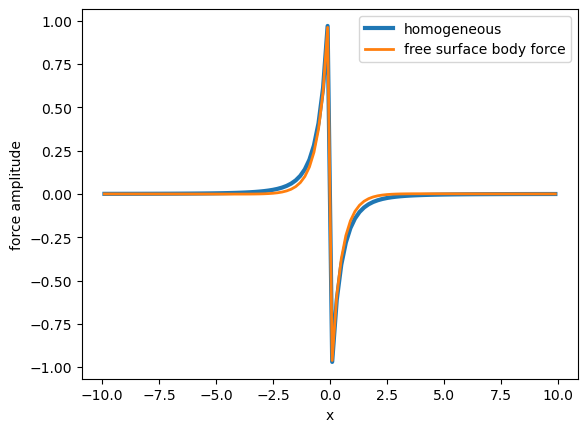

In [5]:
# construct vector for RHS (we only use dudy for the source term because of flat topo)
rhsvec = np.vstack(
    [-dudy0[topoindex].reshape(-1, 1), (beta * dudy0[~topoindex]).reshape(-1, 1)]
)
print("Condition number of system: " + str(np.linalg.cond(kernel)))
solvec = np.linalg.inv(kernel) @ rhsvec

# solve for purely topographic contribution
toposolvec = np.linalg.inv(K_y[topoindex][:, topoindex]) @ (
    -dudy0[topoindex].reshape(-1, 1)
)

plt.figure()
plt.plot(els.x_centers[topoindex], toposolvec, "-", linewidth=3, label="homogeneous")
plt.plot(
    els.x_centers[topoindex],
    solvec[topoindex],
    "-",
    linewidth=2,
    label="free surface body force",
)
# plt.plot(els.x_centers[~topoindex], solvec[~topoindex], "-", label="body force")
plt.legend()
plt.ylabel("force amplitude")
plt.xlabel("x")
plt.show()

# Construct kernels for line+triangle force elements

In [6]:
# Construct stress kernels for triangle elements
# what we need to compute kernels: node_coords, triangle
Ntopo = len(els_topo.x1)
xo = np.hstack([(els_topo.x_centers + dr * els_topo.x_normals), xm.flatten()])
yo = np.hstack([(els_topo.y_centers + dr * els_topo.y_normals), ym.flatten()])

K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_slip_antiplane(
    xo, yo, els_source, mu
)

# compute grad(u) due to source at els
# (σ = 2με, ε = grad(u)/2 i.e., du/dx = σ/μ)
dudx0 = K_sx @ quadcoefs
dudy0 = K_sy @ quadcoefs

# compute els_topo force kernels [Nobs x 2 x Nsources]
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_force_antiplane(
    xo, yo, els_topo, mu
)
# triangle kernels
K_tx = np.zeros((Ntopo + Ntri, Ntri))
K_ty = np.zeros_like(K_tx)
for i in range(0, Ntri):
    tricoords = np.vstack(
        [node_coords[triangles[i, :], 0], node_coords[triangles[i, :], 1]]
    ).T
    _, _, sy = bemcs.displacements_stresses_triangle_force_antiplane(
        tricoords, xo, yo, fval=1.0, mu=mu
    )
    K_ty[:, i] = sy

# combine line + trimesh stress kernels
K_x = np.block([np.sum(K_sx, axis=1), K_tx])
K_y = np.block([np.sum(K_sy, axis=1), K_ty])

For this we will assume that $\mu(y)$ linearly varies from $y_{top} \to y_{bot}$ from `mu_shallow` to `mu_deep`. 

So $\beta(y) = -\frac{1}{\mu(y)}\frac{\mu_{top}-\mu_{bot}}{y_{top}-y_{bot}}$

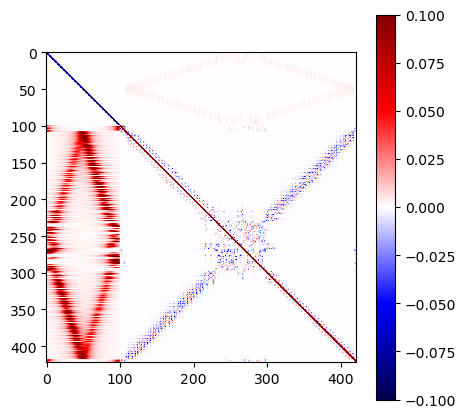

In [7]:
topoindex_tri = np.zeros(len(xo), dtype=bool)
topoindex_tri[0:Ntopo] = True

deltay = np.max(node_coords[:, 1]) - np.min(node_coords[:, 1])
muval = (ym - np.min(node_coords[:, 1])) / deltay * (mu_shallow - mu_deep) + mu_deep
betavec = -1 / muval * (mu_shallow - mu_deep) / deltay

kernel = np.vstack(
    [
        np.hstack(
            [
                K_y[topoindex_tri][:, topoindex_tri],
                K_y[topoindex_tri][:, ~topoindex_tri],
            ]
        ),
        np.hstack(
            [
                -betavec * K_y[~topoindex_tri][:, topoindex_tri],
                np.eye(Ntri) - betavec * K_y[~topoindex_tri][:, ~topoindex_tri],
            ]
        ),
    ]
)

plt.figure(figsize=(5, 5))
plt.imshow(kernel, cmap="seismic")
plt.colorbar()
plt.clim([-0.1, 0.1])
plt.show()

## Construct RHS for BEM and solve system of equations

Condition number of system: 16.227924304548136


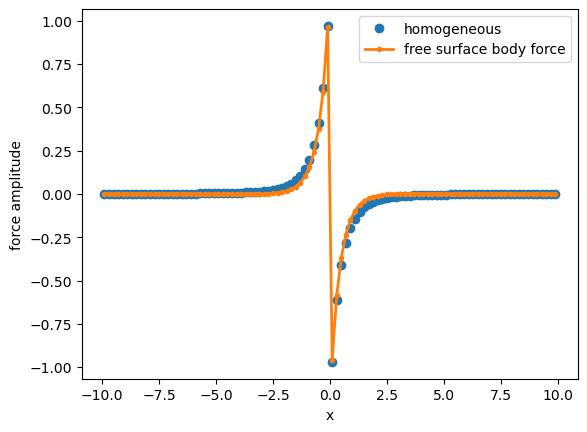

In [8]:
# construct vector for RHS (we only use dudy for the source term because of flat topo)
rhsvec = np.concatenate(
    (-dudy0[topoindex_tri], (betavec.flatten() * dudy0[~topoindex_tri]))
)
print("Condition number of system: " + str(np.linalg.cond(kernel)))
solvec_tri = np.linalg.inv(kernel) @ rhsvec


plt.figure()
plt.plot(els_topo.x_centers, toposolvec, "o", linewidth=3, label="homogeneous")
plt.plot(
    els_topo.x_centers,
    solvec_tri[topoindex_tri],
    ".-",
    linewidth=2,
    label="free surface body force",
)
plt.legend()
plt.ylabel("force amplitude")
plt.xlabel("x")
plt.show()

# Plot results

In [9]:
# plot resulting displacement field
nx_obs = 200
ny_obs = 100
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 0, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

## Compute relevant kernels for all 3 problems and plot results

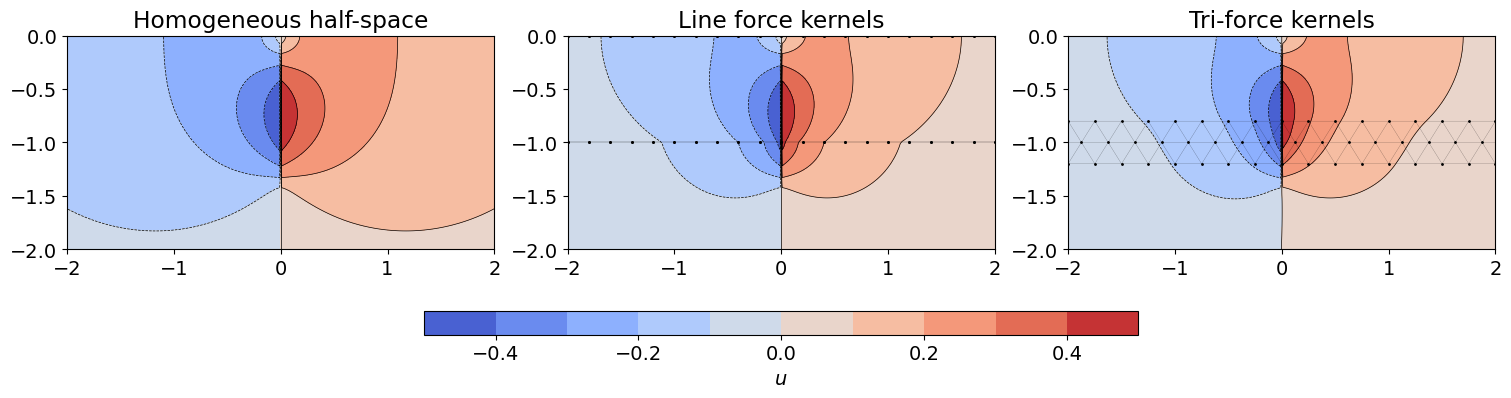

In [10]:
# compute kernels for line force mesh elements
_, _, K_u = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els, mu)
Ku = np.sum(K_u, axis=1)

# compute kernels for source fault
_, _, Ku0 = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els_source, mu)
# compute displacements
u_line = Ku @ solvec + Ku0 @ quadcoefs.reshape(-1, 1)
u_topo = Ku[:, topoindex] @ toposolvec + Ku0 @ quadcoefs.reshape(-1, 1)

# topographic line force kernels
_, _, K_u = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els_topo, mu)
Ku = np.sum(K_u, axis=1)
# triangle kernels
K_tu = np.zeros((len(xo), Ntri))
for i in range(0, Ntri):
    tricoords = np.vstack(
        [node_coords[triangles[i, :], 0], node_coords[triangles[i, :], 1]]
    ).T
    u, _, _ = bemcs.displacements_stresses_triangle_force_antiplane_farfield(
        tricoords, xo.flatten(), yo.flatten(), fval=1.0, mu=mu
    )
    K_tu[:, i] = u

# compute displacements due to tri-force and line forces on topo
u_tri = (
    Ku @ solvec_tri[topoindex_tri].reshape(-1, 1)
    + K_tu @ solvec_tri[~topoindex_tri].reshape(-1, 1)
    + Ku0 @ quadcoefs.reshape(-1, 1)
)
# Set global font size
plt.rcParams.update({"font.size": 14})  # Change to desired font size
maxval = 0.5
minval = -maxval
levels = np.linspace(minval, maxval, 11)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7), constrained_layout=True)
toplot = u_topo.reshape(ny_obs, nx_obs)
# Plot the first subplot
c1 = ax1.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
ax1.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
ax1.set_aspect("equal", adjustable="box")
ax1.set_title("Homogeneous half-space")

# Plot the second subplot
toplot = u_line.reshape(ny_obs, nx_obs)
c2 = ax2.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
ax2.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
for i in range(len(els.x1)):
    ax2.plot(
        [els.x1[i], els.x2[i]],
        [els.y1[i], els.y2[i]],
        "k.-",
        linewidth=0.2,
        markersize=2,
    )
ax2.set_xlim([-2, 2])
ax2.set_aspect("equal", adjustable="box")
ax2.set_title("Line force kernels")

# Plot the third subplot
toplot = u_tri.reshape(ny_obs, nx_obs)
c2 = ax3.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
ax3.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
ax3.triplot(
    node_coords[:, 0], node_coords[:, 1], triangles, "k.-", linewidth=0.1, markersize=2
)
ax3.set_xlim([-2, 2])
ax3.set_aspect("equal", adjustable="box")
ax3.set_title("Tri-force kernels")
# Add a common colorbar
fig.colorbar(
    c1,
    ax=[ax1, ax2, ax3],
    orientation="horizontal",
    label="$u$",
    ticks=[-0.4, -0.2, 0, 0.2, 0.4],
    shrink=0.5,
    aspect=30,
)

# Display the plot
plt.show()
# fig.savefig("bimaterial_comparisonfigure.pdf", format="pdf", dpi=300)

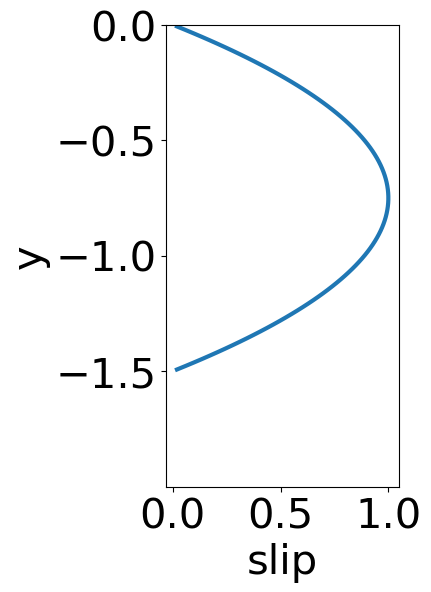

In [41]:
"""plt.figure(figsize=(12, 5))
toplot = sy.reshape(ny_obs, nx_obs)
maxval = 2.0
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="rainbow",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
plt.triplot(node_coords[:, 0], node_coords[:, 1], triangles, "k.-", linewidth=0.5)
plt.colorbar(label="$\sigma_x$")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.xlim([-2, 2])
plt.ylim([-2, 0])
plt.clim([minval, maxval])
plt.title("bimaterial (triangle forces)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()"""

plt.rcParams.update({"font.size": 30})  # Change to desired font size
_, ynodes, slipnodes = bemcs.get_slipvector_on_fault_antiplane(
    els_source, quadcoefs.flatten(), 100
)
fig = plt.figure(figsize=(3, 6))
plt.plot(slipnodes, ynodes, "-", linewidth=3)
plt.xlabel("slip")
plt.ylabel("y")
plt.ylim([-2, 0])
plt.yticks([-1.5, -1, -0.5, 0])
plt.xticks([0, 0.5, 1])
plt.show()
fig.savefig("bimaterial_faultslip.pdf", format="pdf", dpi=200, bbox_inches="tight")